In [8]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import stats
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
from typing import Tuple, Dict
from typing import Dict, Tuple, List, Optional

from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from plume_sim import ParallelOdorPredictor
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
import sys
sys.path.append("../")
from cfd_rigolli import Cfd_rigolli
from mpl_toolkits.axes_grid1 import make_axes_locatable
import multiprocessing as mp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
class SurgeCastAgent:
    def __init__(self, tau=0.42, noise=1.9, bias=0.25, threshold=4.5,
                 hit_trigger='peak', surge_amp=2.0, tau_surge=0.5,
                 cast_freq=1.0, cast_width=0.8, bounds=None):
        self.tau = tau
        self.noise = noise
        self.bias = bias
        self.threshold = threshold
        self.hit_trigger = hit_trigger
        self.surge_amp = surge_amp
        self.tau_surge = tau_surge
        self.cast_freq = cast_freq
        self.cast_width = cast_width
        self.bounds = bounds
        self.surge_amp_ = surge_amp / (tau_surge * np.exp(-1))

    def reflect_if_out_of_bounds(self, v: np.ndarray, x: np.ndarray):
        if self.bounds is None:
            return v, x
        v_new = v.copy()
        x_new = x.copy()
        for dim in range(2):
            if x[dim] < self.bounds[dim][0]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][0] - x[dim]
            elif x[dim] > self.bounds[dim][1]:
                v_new[dim] *= -1
                x_new[dim] = 2*self.bounds[dim][1] - x[dim]
        return v_new, x_new


def tracking(
    predictor, 
    bounds, 
    start_pos, 
    target_pos, 
    surge_agent, 
    target_weight, 
    plume_timeout, 
    closest_to_source, 
    duration
):
    dt = 0.005
    n_steps = int(duration / dt)

    ts = np.arange(n_steps)*dt
    odors = np.zeros(n_steps)
    surges = np.zeros(n_steps)
    bs = np.zeros((n_steps,2))
    vs = np.zeros((n_steps,2))
    xs = np.zeros((n_steps,2))
    hits = np.zeros(n_steps)

    x = start_pos.copy()
    v = np.zeros(2)
    last_hit_time = -np.inf
    last_odor = 0
    hit_occurred = False

    # initial bias
    to_target = target_pos - x
    to_target /= (np.linalg.norm(to_target) + 1e-6)
    upwind = np.array([-1.0, 0.0])
    b = (1 - target_weight)*upwind + target_weight*to_target
    b *= (surge_agent.bias / np.linalg.norm(b))

    for t_ctr in range(n_steps):
        # -- NEW: single-step odor update --
        current_odor = predictor.step_update(x[0], x[1], dt)
        odors[t_ctr] = current_odor

        # "peak" trigger logic
        if surge_agent.hit_trigger == 'peak':
            if current_odor >= surge_agent.threshold:
                # check if it's going back down from a local peak
                if current_odor <= last_odor and not hit_occurred:
                    hits[t_ctr] = 1
                    hit_occurred = True
                    last_hit_time = t_ctr*dt
                    # Calculate surge force profile
                    remaining_steps = n_steps - t_ctr
                    ts_ = ts[:remaining_steps] - ts[0]
                    surge_force = surge_agent.surge_amp_ * ts_ * np.exp(-ts_/surge_agent.tau_surge)
                    surges[t_ctr:] = np.minimum(surge_force, 50.0)
                last_odor = current_odor
            else:
                last_odor = 0
                hit_occurred = False

        # Movement logic
        if t_ctr > 0:
            eta = np.random.normal(0, surge_agent.noise, 2)
            time_since_hit = (t_ctr*dt - last_hit_time)

            # direction to target
            to_target = target_pos - x
            dist_to_target = np.linalg.norm(to_target)
            if dist_to_target < closest_to_source:
                print(f"Target reached at {x}")
                break
            to_target /= (dist_to_target + 1e-6)

            # If no whiff for a while, rely more on upwind
            current_target_weight = target_weight
            if time_since_hit > plume_timeout:
                current_target_weight = min(
                    0.8, 
                    target_weight + 0.1*(time_since_hit - plume_timeout)/plume_timeout
                )

            if surges[t_ctr] > 1.0:  # surging
                surge_direction = np.array([-1.0, -0.05*x[1]])
                surge_direction /= np.linalg.norm(surge_direction)
                b = (1 - current_target_weight)*surge_direction + current_target_weight*to_target
                b *= surges[t_ctr]
            else:
                # cast
                cast_freq = 0.5
                cast_phase = np.sin(2*np.pi*cast_freq*ts[t_ctr])
                base_cast_width = 1.0
                dist_factor = min(1.0, dist_to_target/20.0)
                cast_width = base_cast_width*dist_factor

                crosswind = np.array([0.0, cast_phase*cast_width])
                upwind = np.array([-0.2, 0.0])
                b = (1 - current_target_weight)*(upwind + crosswind) + current_target_weight*to_target
                norm_b = np.linalg.norm(b)
                if norm_b > 0:
                    b *= surge_agent.bias/norm_b

            # update velocity & position
            v += (dt/surge_agent.tau)*(-v + eta + b)
            x += v*dt

            # reflect boundaries
            v, x = surge_agent.reflect_if_out_of_bounds(v, x)

        # store
        bs[t_ctr] = b
        vs[t_ctr] = v
        xs[t_ctr] = x

    # trim if ended early
    if t_ctr < (n_steps-1):
        ts = ts[:t_ctr+1]
        xs = xs[:t_ctr+1]
        bs = bs[:t_ctr+1]
        vs = vs[:t_ctr+1]
        odors = odors[:t_ctr+1]
        hits = hits[:t_ctr+1]
        surges = surges[:t_ctr+1]

    xs[t_ctr] = target_pos  # Set final position to target - remove to see where it actually

    
    fig, axs = plt.subplots(3,1,figsize=(8,8))
    # trajectory
    axs[0].plot(xs[:,0], xs[:,1],'b-', label='Path')
    axs[0].plot(start_pos[0], start_pos[1], 'go', label='Start')
    axs[0].plot(target_pos[0], target_pos[1], 'ro', label='Target')
    # axs[0].plot(xs[-1,0], xs[-1,1], 'mo', label='End')
    whiff_idx = np.where(hits==1)[0]
    if len(whiff_idx)>0:
        axs[0].plot(xs[whiff_idx,0], xs[whiff_idx,1], 'g*', label='Whiffs')
    axs[0].set_title(f'Trajectory (Whiffs: {np.sum(hits)})')
    axs[0].legend()

    # odor
    axs[1].plot(ts, odors, 'b-', label='Odor')
    if len(whiff_idx)>0:
        axs[1].plot(ts[whiff_idx], odors[whiff_idx], 'r*', label='Detected Whiffs')
    axs[1].axhline(surge_agent.threshold, color='r', linestyle='--', label='Threshold')
    axs[1].legend()
    axs[1].set_title('Odor concentration')

    # forces
    axs[2].plot(ts, np.linalg.norm(bs,axis=1),'g-', label='Bias Force')
    axs[2].plot(ts, surges, 'r-', label='Surge Force')
    axs[2].legend()
    axs[2].set_title('Control Forces')
    fig.suptitle('my odor simulator')
    fig.tight_layout()

    
    return odors, xs, ts


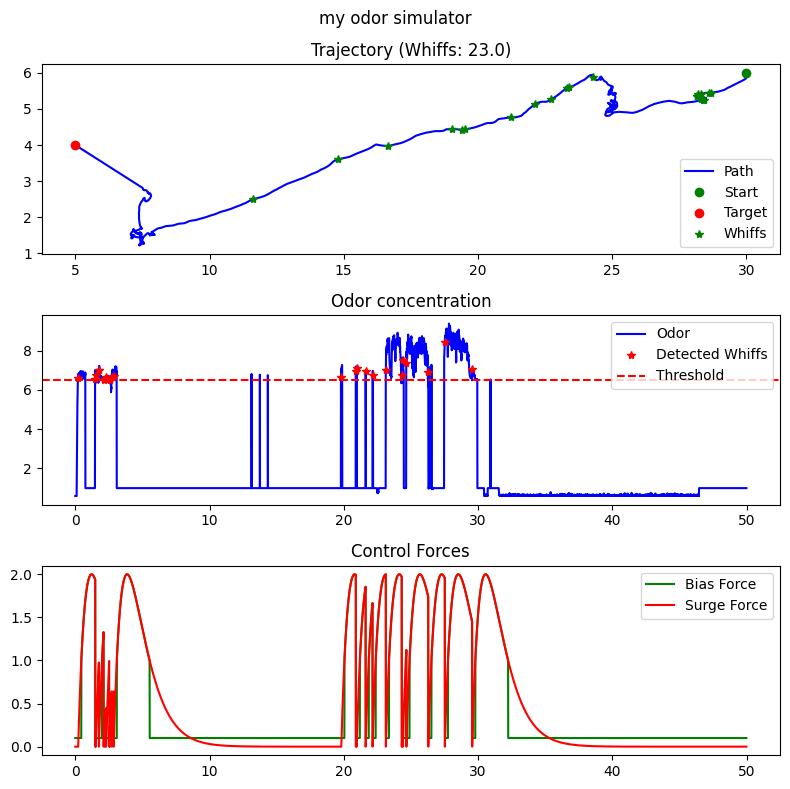

In [11]:
if __name__ == "__main__":
    # Setup simulation parameters
    bounds = [(5, 40), (0, 8)]
    start_pos = np.array([30.0, 6.0])
    target_pos = np.array([5.0, 4.0])
    
    surge_agent = SurgeCastAgent(
        tau=0.3,
        noise=3.0,
        bias=0.1,
        threshold=6.5,
        hit_trigger='peak',
        surge_amp=2.0,
        tau_surge=1.0,
        bounds=bounds
    )
    
    target_weight = 0
    plume_timeout = 10.0
    closest_to_source = 0.2
    sim_duration = 50.0
    
    dirname = '../data/simulator/rigolli/'
    hmap_data = np.load(str(dirname) + "hmap.npz")
    fdf = pd.read_hdf(str(dirname) + 'whiff.h5')
    fdf_nowhiff = pd.read_hdf(str(dirname) + 'nowhiff.h5')

    # 2) Create predictor (no df_test needed for real-time)
    predictor = ParallelOdorPredictor(
        fitted_p_heatmap=hmap_data['fitted_p_heatmap'],
        xedges=hmap_data['xedges'],
        yedges=hmap_data['yedges'],
        fdf=fdf,
        fdf_nowhiff=fdf_nowhiff
    )

    # Run simulation
    odors, trajectories, times = tracking(predictor, bounds, start_pos,target_pos,surge_agent, target_weight,
        plume_timeout, closest_to_source, sim_duration )

(6000.0, 7000.0)

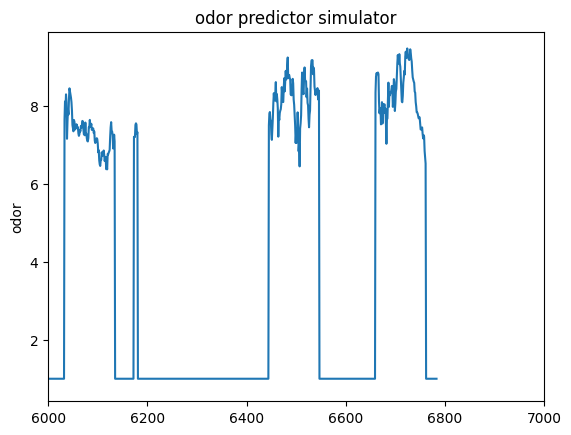

In [31]:
plt.plot(odors)
plt.ylabel('odor')
plt.title('odor predictor simulator')
plt.xlim(6000,7000)

Rigolli Tracker

In [45]:
class CfdOdorPredictor:
    def __init__(self, cfd_simulator, scale_data_fn):
        self.cfd = cfd_simulator
        self.scale_data = scale_data_fn
        self.config = type('Config', (), {
            'warmup_steps': 0,
            'rows_per_second': 200
        })()

    def get_wind_at_position(self, pos: Tuple[float, float], time: float) -> Tuple[float, float, float]:
        return self.cfd.get_wind_at_position_and_time(pos, time)

    def get_odor_at_position(self, pos: Tuple[float, float], time: float) -> float:
        odor = self.cfd.get_odor_at_position_and_time(pos, time)
        return odor


def scale_data(data):
    min_val = 0
    max_val = 17.2
    return (((data - min_val) / (max_val - min_val)) * 10)

def cfd_tracking(
    cfd_predictor,
    bounds,
    start_pos,
    target_pos,
    surge_agent,
    target_weight,
    plume_timeout,
    closest_to_source,
    duration
):
    dt = 0.005
    n_steps = int(duration / dt)
    ts = np.arange(n_steps) * dt

    # Arrays for storage
    xs = np.zeros((n_steps, 2))
    vs = np.zeros((n_steps, 2))
    bs = np.zeros((n_steps, 2))
    hits = np.zeros(n_steps, dtype=int)
    surges = np.zeros(n_steps)
    raw_odors = np.zeros(n_steps)
    scaled_odors = np.zeros(n_steps)

    # We'll also store wind from CFD (for reference) but not use it
    # stored_winds = np.zeros((n_steps, 2))

    # Initial state
    x = start_pos.copy()
    v = np.zeros(2)
    xs[0] = x

    last_hit_time = -np.inf
    last_odor = 0.0
    hit_occurred = False

    # Hard-coded upwind direction:
    upwind = np.array([-1.0, 0.0])

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Main loop
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for t_ctr in range(1, n_steps):
        current_time = ts[t_ctr]

        # 1) Get raw odor from CFD, scale it
        raw_odor = cfd_predictor.get_odor_at_position(tuple(x), current_time)
        odor = scale_data(raw_odor)
        raw_odors[t_ctr] = raw_odor
        scaled_odors[t_ctr] = odor

        # 2) Retrieve the CFD wind (but do not use for steering)
        # wind_vel = cfd_predictor.get_wind_at_position(tuple(x), current_time)
        # stored_winds[t_ctr] = [wind_vel[0], wind_vel[1]]

        # 3) Whiff detection in real time ("peak" logic)
        if surge_agent.hit_trigger == 'peak':
            if odor >= surge_agent.threshold:
                # If it's going down from local max and wasn't marked:
                if (odor <= last_odor) and (not hit_occurred):
                    hits[t_ctr] = 1
                    hit_occurred = True
                    last_hit_time = current_time

                    # define surge from now on
                    remaining_steps = n_steps - t_ctr
                    local_ts = ts[:remaining_steps] - ts[t_ctr]
                    surge_profile = surge_agent.surge_amp_ * local_ts * np.exp(-local_ts / surge_agent.tau_surge)
                    surges[t_ctr:] = np.minimum(surge_profile, 50.0)

                last_odor = odor
            else:
                last_odor = 0
                hit_occurred = False

        # 4) Movement logic
        #    a) check if we've reached target
        to_target = target_pos - x
        dist_to_target = np.linalg.norm(to_target)
        if dist_to_target < closest_to_source:
            print(f"Target reached at ({x[0]:.2f}, {x[1]:.2f}) on step {t_ctr}")
            xs[t_ctr] = x
            break

        if dist_to_target > 1e-12:
            to_target /= dist_to_target
        else:
            to_target = upwind  # fallback if target is basically x

        #    b) If no whiff for a while, rely more on upwind
        time_since_hit = current_time - last_hit_time
        current_target_weight = target_weight
        if time_since_hit > plume_timeout:
            current_target_weight = min(
                0.8,
                target_weight + 0.1*(time_since_hit - plume_timeout)/plume_timeout
            )

        #    c) Are we surging or casting?
        surge_val = surges[t_ctr]
        if surge_val > 1.0:
            # Surging => blend upwind + target
            b = (1 - current_target_weight)*upwind + current_target_weight*to_target
            b *= surge_val
        else:
            # Casting => define crosswind based on a simple sinusoid, same style as your other code
            cast_freq = surge_agent.cast_freq
            cast_phase = np.sin(2*np.pi*cast_freq*current_time)
            base_cast_width = surge_agent.cast_width
            dist_factor = min(1.0, dist_to_target/20.0)
            cast_width = base_cast_width * dist_factor

            crosswind = np.array([0.0, cast_phase * cast_width])
            # partial upwind
            upwind_vec = np.array([-0.2, 0.0])
            b = (1 - current_target_weight)*(upwind_vec + crosswind) + current_target_weight*to_target

            norm_b = np.linalg.norm(b)
            if norm_b > 1e-12:
                b *= surge_agent.bias / norm_b

        #    d) Add noise + integrate
        eta = np.random.normal(0, surge_agent.noise, 2)
        v += (dt / surge_agent.tau)*(-v + eta + b)
        x += v * dt

        #    e) reflect boundaries
        v, x = surge_agent.reflect_if_out_of_bounds(v, x)

        #    f) store
        xs[t_ctr] = x
        vs[t_ctr] = v
        bs[t_ctr] = b

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Slicing arrays if loop ended early
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    final_step = t_ctr + 1
    xs = xs[:final_step]
    vs = vs[:final_step]
    bs = bs[:final_step]
    hits = hits[:final_step]
    surges = surges[:final_step]
    raw_odors = raw_odors[:final_step]
    scaled_odors = scaled_odors[:final_step]
    # stored_winds = stored_winds[:final_step]

    ts = ts[:final_step]

    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Plot
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    fig, axs = plt.subplots(3, 1, figsize=(9,9))

    # 1) Trajectory
    axs[0].plot(xs[:,0], xs[:,1], 'b-', label='Path')
    axs[0].plot(start_pos[0], start_pos[1], 'go', label='Start')
    axs[0].plot(target_pos[0], target_pos[1], 'ro', label='Target')
    axs[0].plot(xs[-1,0], xs[-1,1], 'mo', label='End')
    whiff_idx = np.where(hits == 1)[0]
    if len(whiff_idx)>0:
        axs[0].plot(xs[whiff_idx,0], xs[whiff_idx,1], 'r*', label='Whiffs')
    axs[0].set_title(f"Trajectory (Whiffs: {np.sum(hits)})")
    axs[0].legend()

    # 2) Odor
    axs[1].plot(ts, scaled_odors, 'b-', label='Scaled Odor')
    axs[1].plot(ts, raw_odors, 'g--', alpha=0.6, label='Raw Odor')
    if len(whiff_idx) > 0:
        axs[1].plot(ts[whiff_idx], scaled_odors[whiff_idx], 'r*', label='Detected Whiff')
    axs[1].axhline(surge_agent.threshold, color='r', linestyle='--', label=f"Threshold={surge_agent.threshold}")
    axs[1].set_title("Odor vs Time")
    axs[1].legend()

    # 3) Forces
    axs[2].plot(ts, np.linalg.norm(bs, axis=1), 'g-', label='Bias Force')
    axs[2].plot(ts, surges, 'r-', label='Surge Force')
    axs[2].set_title("Control Forces")
    axs[2].legend()

    fig.tight_layout()
    plt.show()

    # Print some stats
    print("\nTracking Statistics:")
    print(f"Duration:         {len(ts)*dt:.1f} s")
    print(f"Total steps:      {len(ts)}")
    print(f"Whiffs detected:  {int(np.sum(hits))}")
    print(f"Raw odor range:   {raw_odors.min():.3f} to {raw_odors.max():.3f}")
    print(f"Scaled odor:      {scaled_odors.min():.3f} to {scaled_odors.max():.3f}")
    above_thresh = 100.0 * np.mean(scaled_odors > surge_agent.threshold)
    print(f"Time above thr.:  {above_thresh:.1f}%")

    return scaled_odors, xs, ts




Target reached at (5.06, 4.19) on step 10457


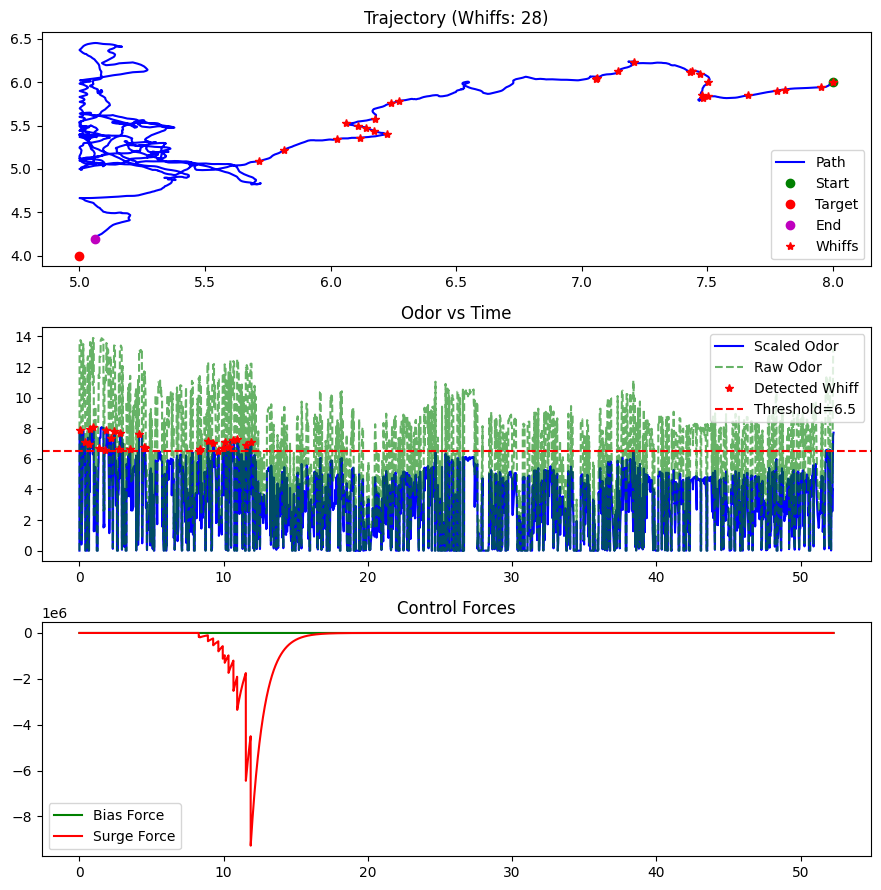


Tracking Statistics:
Duration:         52.3 s
Total steps:      10458
Whiffs detected:  28
Raw odor range:   0.000 to 13.901
Scaled odor:      0.000 to 8.082
Time above thr.:  5.3%


In [47]:
cfd = Cfd_rigolli(dirname="../data/rigolli/")
cfd_predictor = CfdOdorPredictor(cfd, scale_data)

bounds = [(5, 40), (0, 8)]
start_pos = np.array([8.0, 6.0])
target_pos = np.array([5.0, 4.0])

# Create surge-cast agent (same as before)
# Create surge-cast agent
surge_agent = SurgeCastAgent(
    tau=0.3,           # Timescale of turning
    noise=3,            # Noise for casting
    bias=0.1,          # Reduced casting bias
    threshold=6.5,      # Threshold for whiff detection
    hit_trigger='peak',
    surge_amp=2.0,      # Surge amplitude
    tau_surge=1,        # Surge duration
    bounds=bounds
)

target_weight = 0    
plume_timeout = 10.0    
closest_to_source =0.2
# Simulation parameters
sim_duration = 100.0  # seconds


result, trajectories, times = cfd_tracking(
    cfd_predictor, 
    bounds, 
    start_pos, 
    target_pos, 
    surge_agent, 
    target_weight, 
    plume_timeout, 
    closest_to_source, 
    sim_duration
)

(0.0, 200.0)

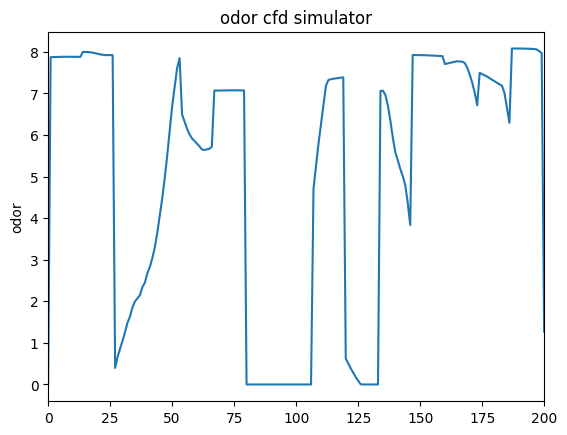

In [61]:
plt.plot(result)
plt.ylabel('odor')
plt.title('odor cfd simulator')
plt.xlim(0,200)

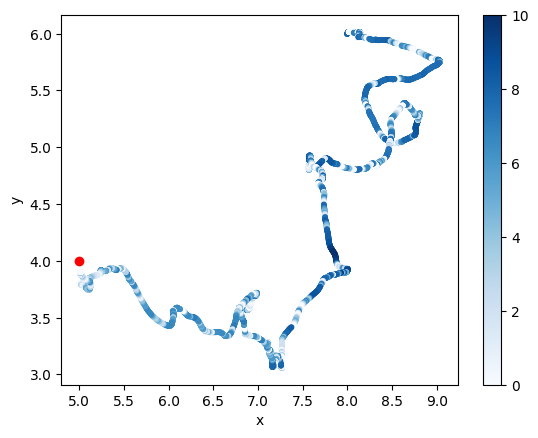

In [30]:
plt.scatter(trajectories[:, 0],trajectories[:, 1], c=result, cmap='Blues', s=10, vmin=0, vmax=10)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.plot(5,4,'o', c='red')

In [18]:
th=4.5
query1 = 'odor>'+str(th)
new_test_df1=pd.DataFrame()
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+str(th)
new_test_df2=pd.DataFrame()
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

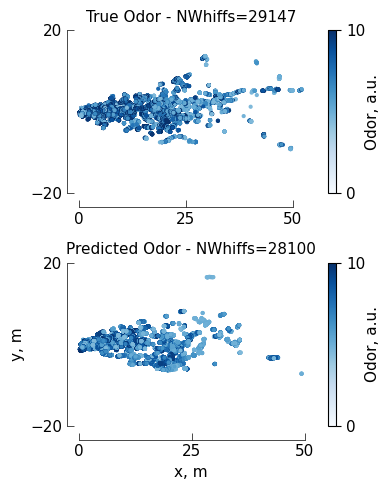

In [19]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
# cax3 = ax[2].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.whiff_predicted, s = 4, cmap='Blues', vmin=0, vmax=1)
# ylim=(-15,25)

ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')

cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)

cb1.set_label('Odor, a.u.',labelpad=0)
cb2.set_label('Odor, a.u.',labelpad=0)


cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
# cb3.set_ticks([0, 1])
for i in range(2):
    # mpl_functions.adjust_spines(ax[i],['left','bottom'],
    #                         spine_locations={'left': 1}, 
    #                         smart_bounds=True,
    #                         xticks=[0,25,50],
    #                         yticks=[0,8],
    #                         linewidth=0.5)
    # mpl_functions.set_fontsize(ax[i],11)
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                        spine_locations={'left': 1}, 
                        smart_bounds=True,
                        xticks=[0,25,50],
                        yticks=[-20,20],
                        linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

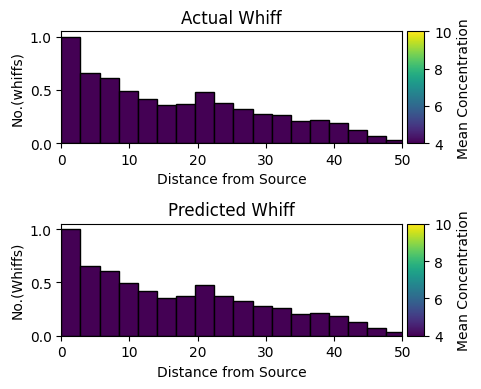

In [17]:
# Number of bins and plot limits
n_bins = 20
# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts
whiff_counts_actual_normalized = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_normalized = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(5, 4))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_normalized, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)
cbar_actual.set_label('Mean Concentration')

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('No.(whiffs)')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(ylim)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_normalized, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_ylabel('No.(Whiffs)')
ax[1].set_title('Predicted Whiff')
ylim = (0, 1)
# ax[1].set_ylim(ylim)
ax[1].set_xlim(0, 50)

# Adjust the layout
f.tight_layout()



In [8]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

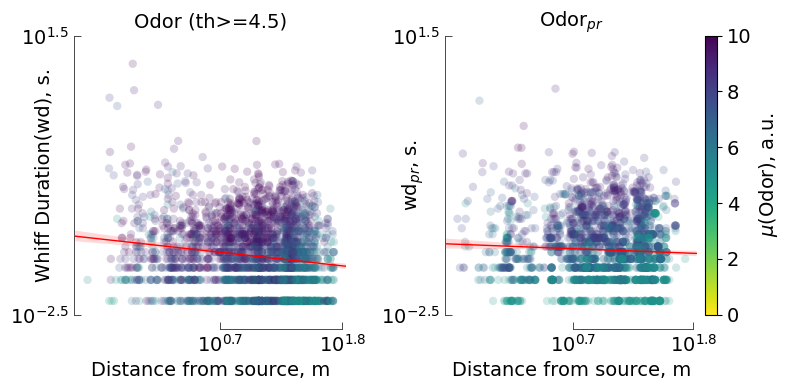

In [9]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10)
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('Whiff Duration(wd), s.')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            yticks=[-2.5,1.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0.7,1.8],
                            yticks=[-2.5,1.5],
                            linewidth=0.5)
ax1.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax1.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])
ax2.set_yticklabels([r'$10^{-2.5}$',r'$10^{1.5}$'])
ax2.set_xticklabels([r'$10^{0.7}$',r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8944.41it/s]


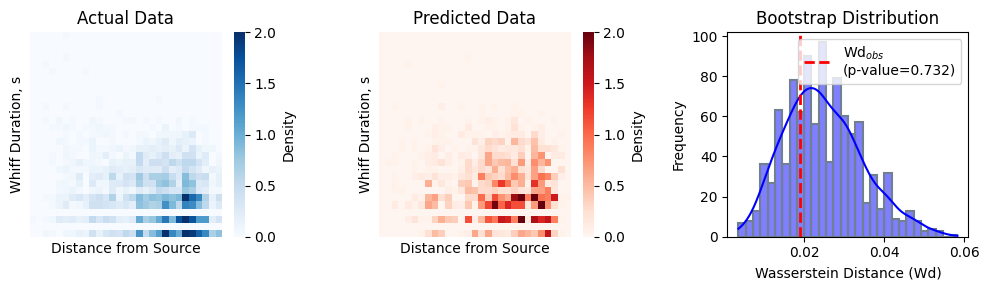

In [10]:
## Duration:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'Whiff Duration, s', 0,2)

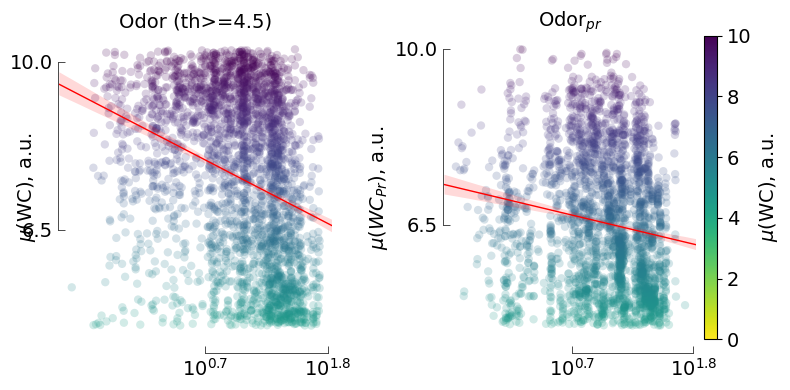

In [11]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var1 = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[6.5, 10],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[6.5, 10],
                            linewidth=0.5)

# Set custom tick labels
# ax1.set_yticklabels([r'$4$', r'$10$'])
ax1.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])
# ax2.set_yticklabels([r'$4$', r'$10$'])
ax2.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9066.45it/s]


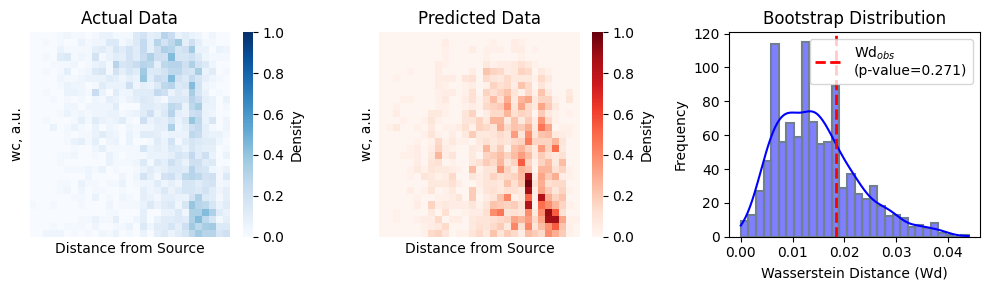

In [12]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.',0,1)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8414.12it/s]


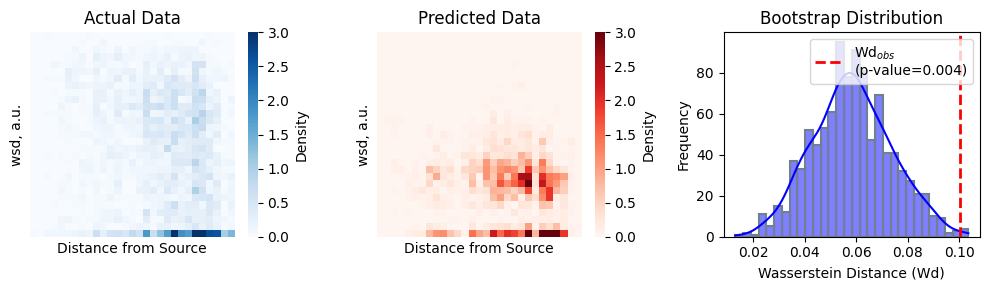

In [13]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,3)

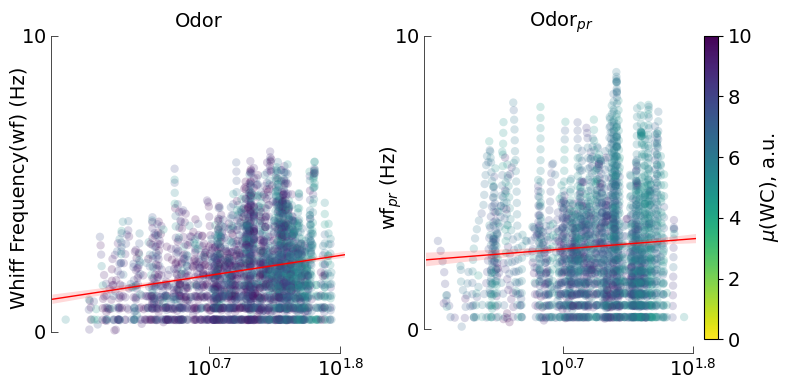

In [14]:
### WHIFF FREQUENCY
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('Whiff Frequency(wf) (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[0,12],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0.7, 1.8],
                            yticks=[0, 12],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{0.7}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 10149.61it/s]


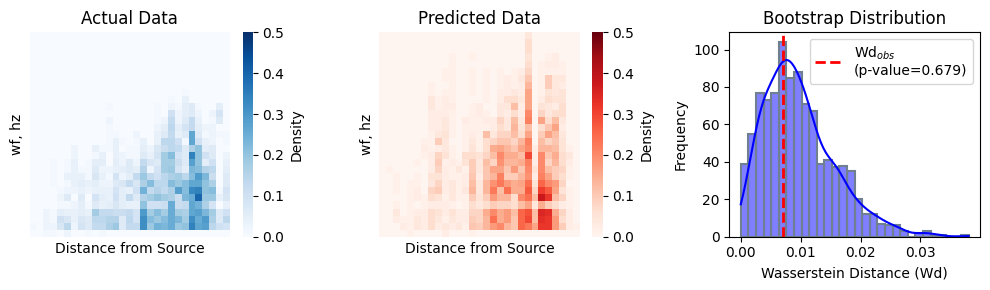

In [15]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz',0,0.5)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9865.56it/s]


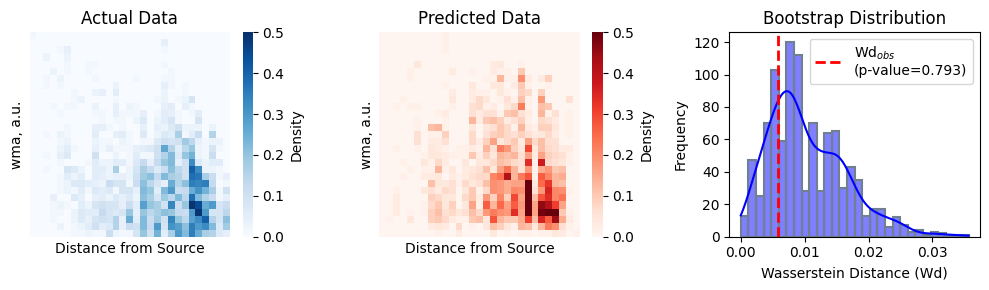

In [16]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wma, a.u.', 0,0.5)